In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_3_crimes_100m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_weekly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)
mask = df['disposition'].str.contains("R 41(a)(1) Voluntary Dismissal on", na=False, regex=False)
df = df.loc[~mask, :]

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_week'
df = df.dropna(subset=treatment_date_variable)
df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_100m        3.534663e-38   
                                                 pre_treatment_change_in_group_3_crimes_100m       2.260190e-06   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                7.218369e-01   
                                                 job_density_2013                                  3.796455e-12   
                                                 med_hhinc2016                                     1.225298e-01   
                                                 poor_share2010                                    4.959622e-04   
                                                 popdensity2010                                    1.062905e-01   
Panel C: Case Initiation                         for_cause                                         7.142459e-01   
                                                 no_cause                                          1.429806e-01   
                                                 non_payment                                       6.867164e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          9.919254e-02   
                                                 hasAttyP                                          1.499262e-01   
                                                 isEntityD                                         6.139623e-01   
                                                 isEntityP                                         1.948439e-02   

                                                                                                            
                                                                                                            
                                                 \emph{Independent Variable}                                
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_100m   3.746556e-02  
                                                 pre_treatment_change_in_group_3_crimes_100m  5.363953e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           8.769456e-02  
                                                 job_density_2013                             1.493548e-02  
                                                 med_hhinc2016                                1.320482e-01  
                                                 poor_share2010                               1.857107e-02  
                                                 popdensity2010                               3.176658e-02  
Panel C: Case Initiation                         for_cause                                    4.977467e-01  
                                                 no_cause                                     6.029598e-05  
                                                 non_payment                                  3.068283e-03  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     2.675542e-28  
                                                 hasAttyP                                     1.900900e-05  
                                                 isEntityD                                    1.421217e-06  
                                                 isEntityP                                    1.730992e-07

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                    Cases Won by Plaintiff   
Panel A total_twenty_seventeen_group_3_crimes_100m                1.093156   
        pre_treatment_change_in_group_3_crimes_100m              -0.045627   
Panel B job_density_2013                                      17324.753036   
        poor_share2010                                            0.275051   
Panel D isEntityP                                                 0.805450   

                                                    Difference in Cases Won by Defendant  \
                                                                              Unweighted   
Panel A total_twenty_seventeen_group_3_crimes_100m                              0.218504   
        pre_treatment_change_in_group_3_crimes_100m                            -0.012201   
Panel B job_density_2013                                                     6144.920135   
        poor_share2010                                                          0.019472   
Panel D isEntityP                                                               0.125784   

                                                                   \
                                                         \emph{p}   
Panel A total_twenty_seventeen_group_3_crimes_100m   3.746556e-02   
        pre_treatment_change_in_group_3_crimes_100m  5.363953e-01   
Panel B job_density_2013                             1.493548e-02   
        poor_share2010                               1.857107e-02   
Panel D isEntityP                                    1.730992e-07   

                                                                            
                                                        Weighted  \emph{p}  
Panel A total_twenty_seventeen_group_3_crimes_100m      0.048908  0.627880  
        pre_treatment_change_in_group_3_crimes_100m    -0.003705  0.851737  
Panel B job_density_2013                             2223.134952  0.361113  
        poor_share2010                                 -0.006864  0.306850  
Panel D isEntityP                                       0.017025  0.191840

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=34]  100%|████████████████████| 17776/17776 [00:20<00:00, 884.88it/s] 


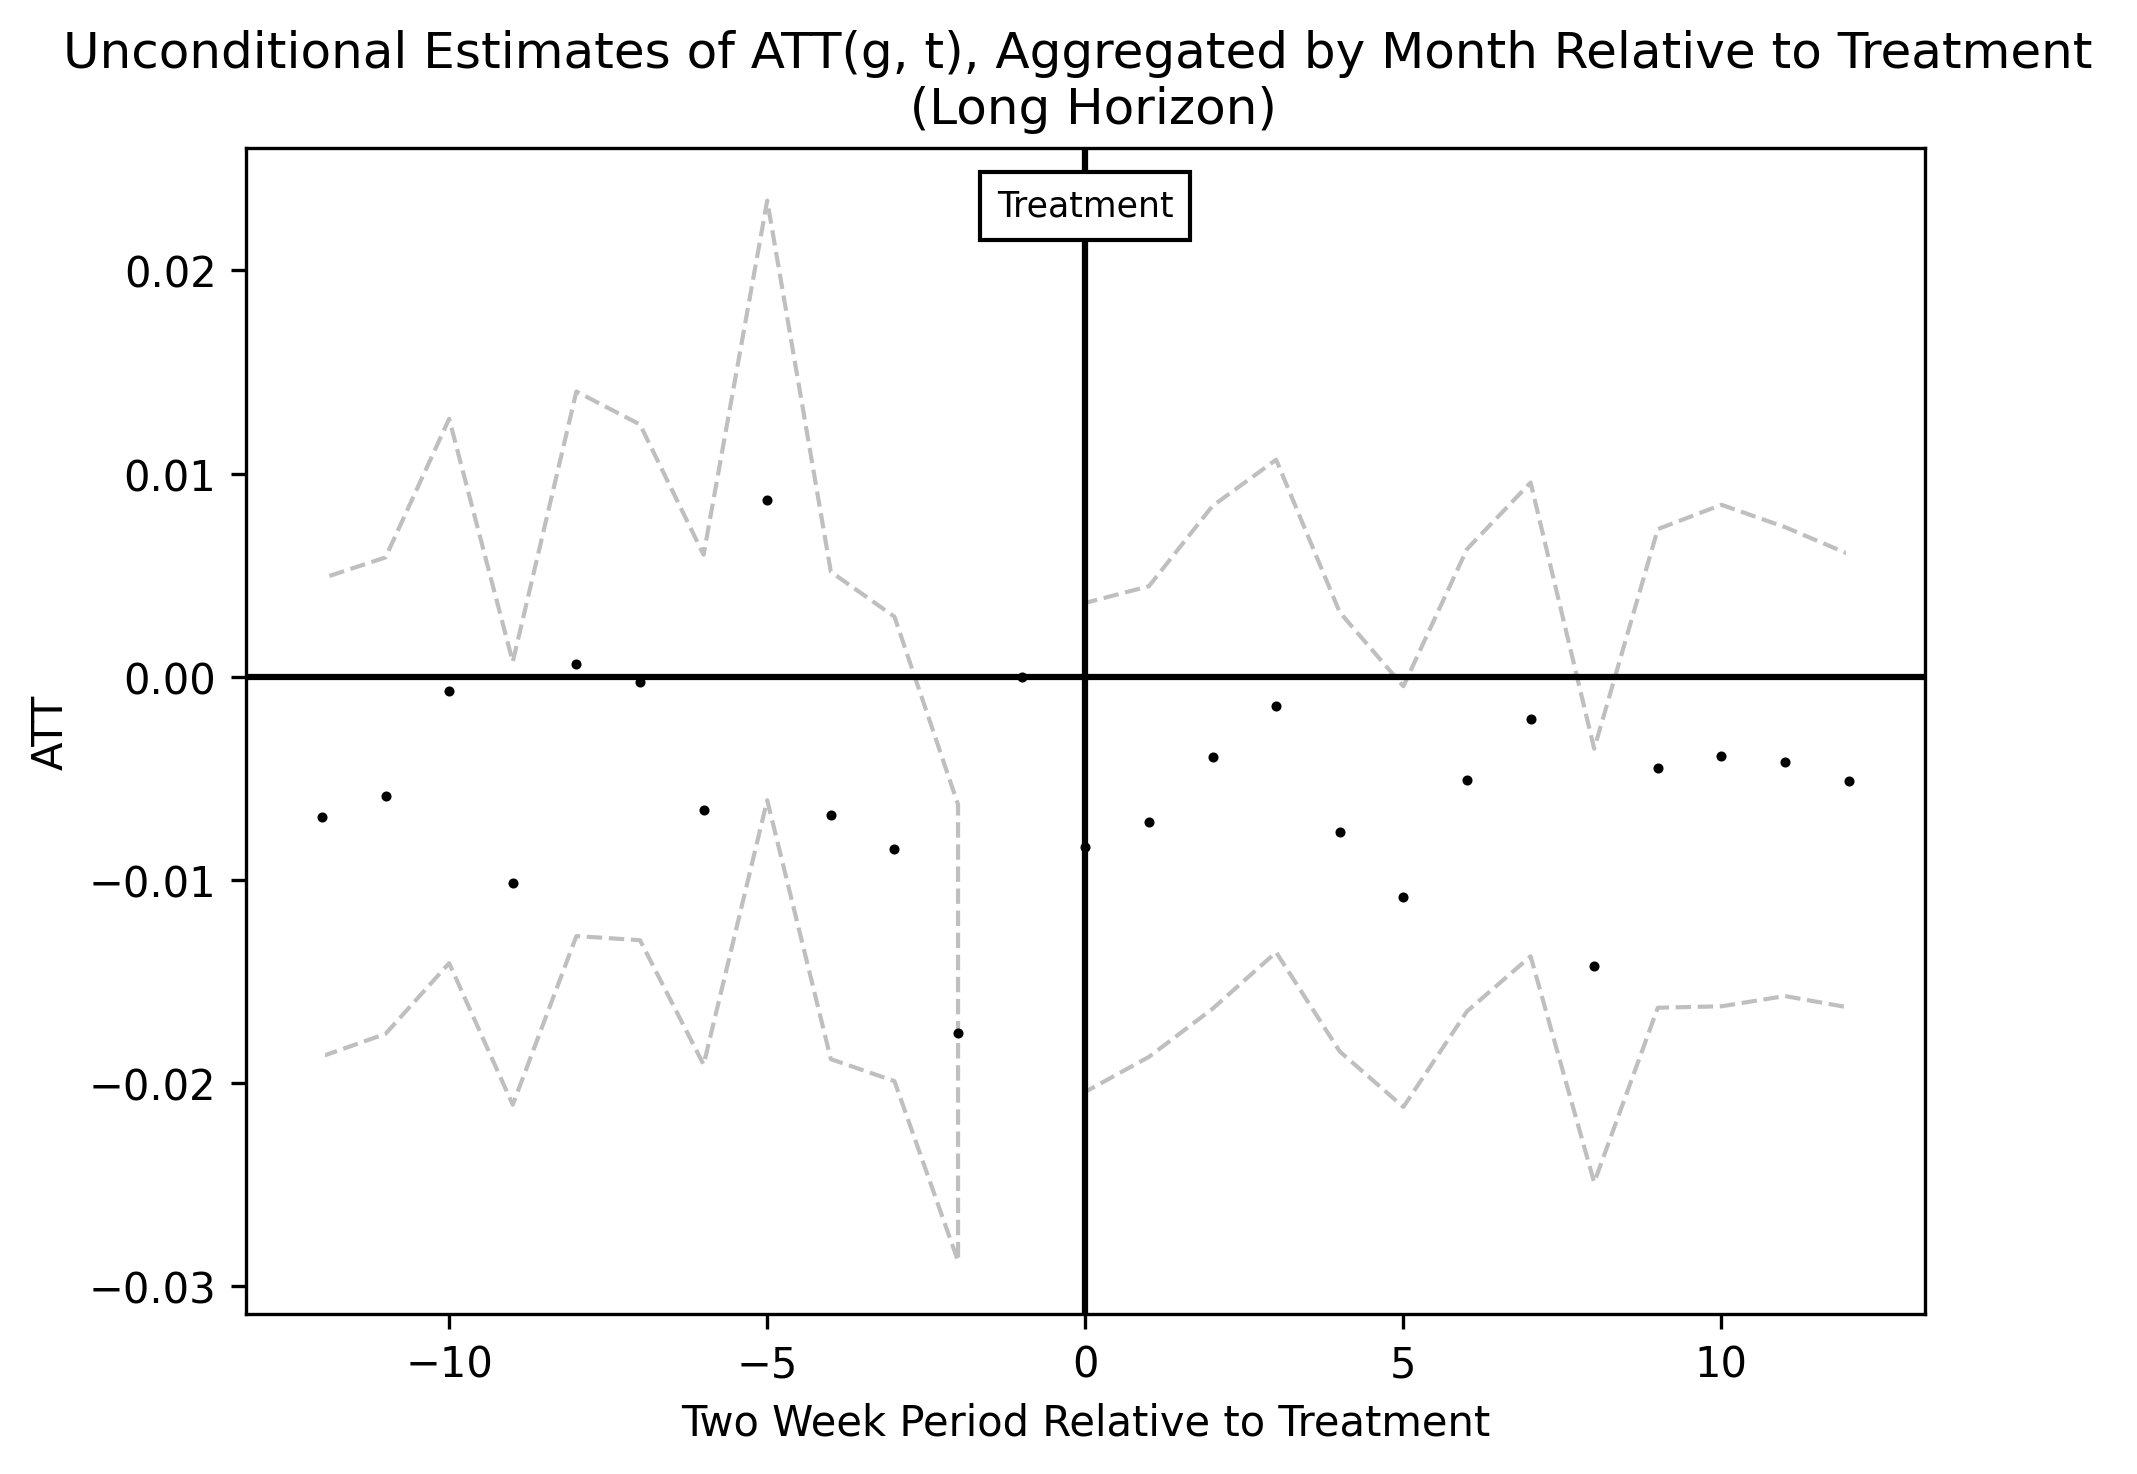

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=12,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

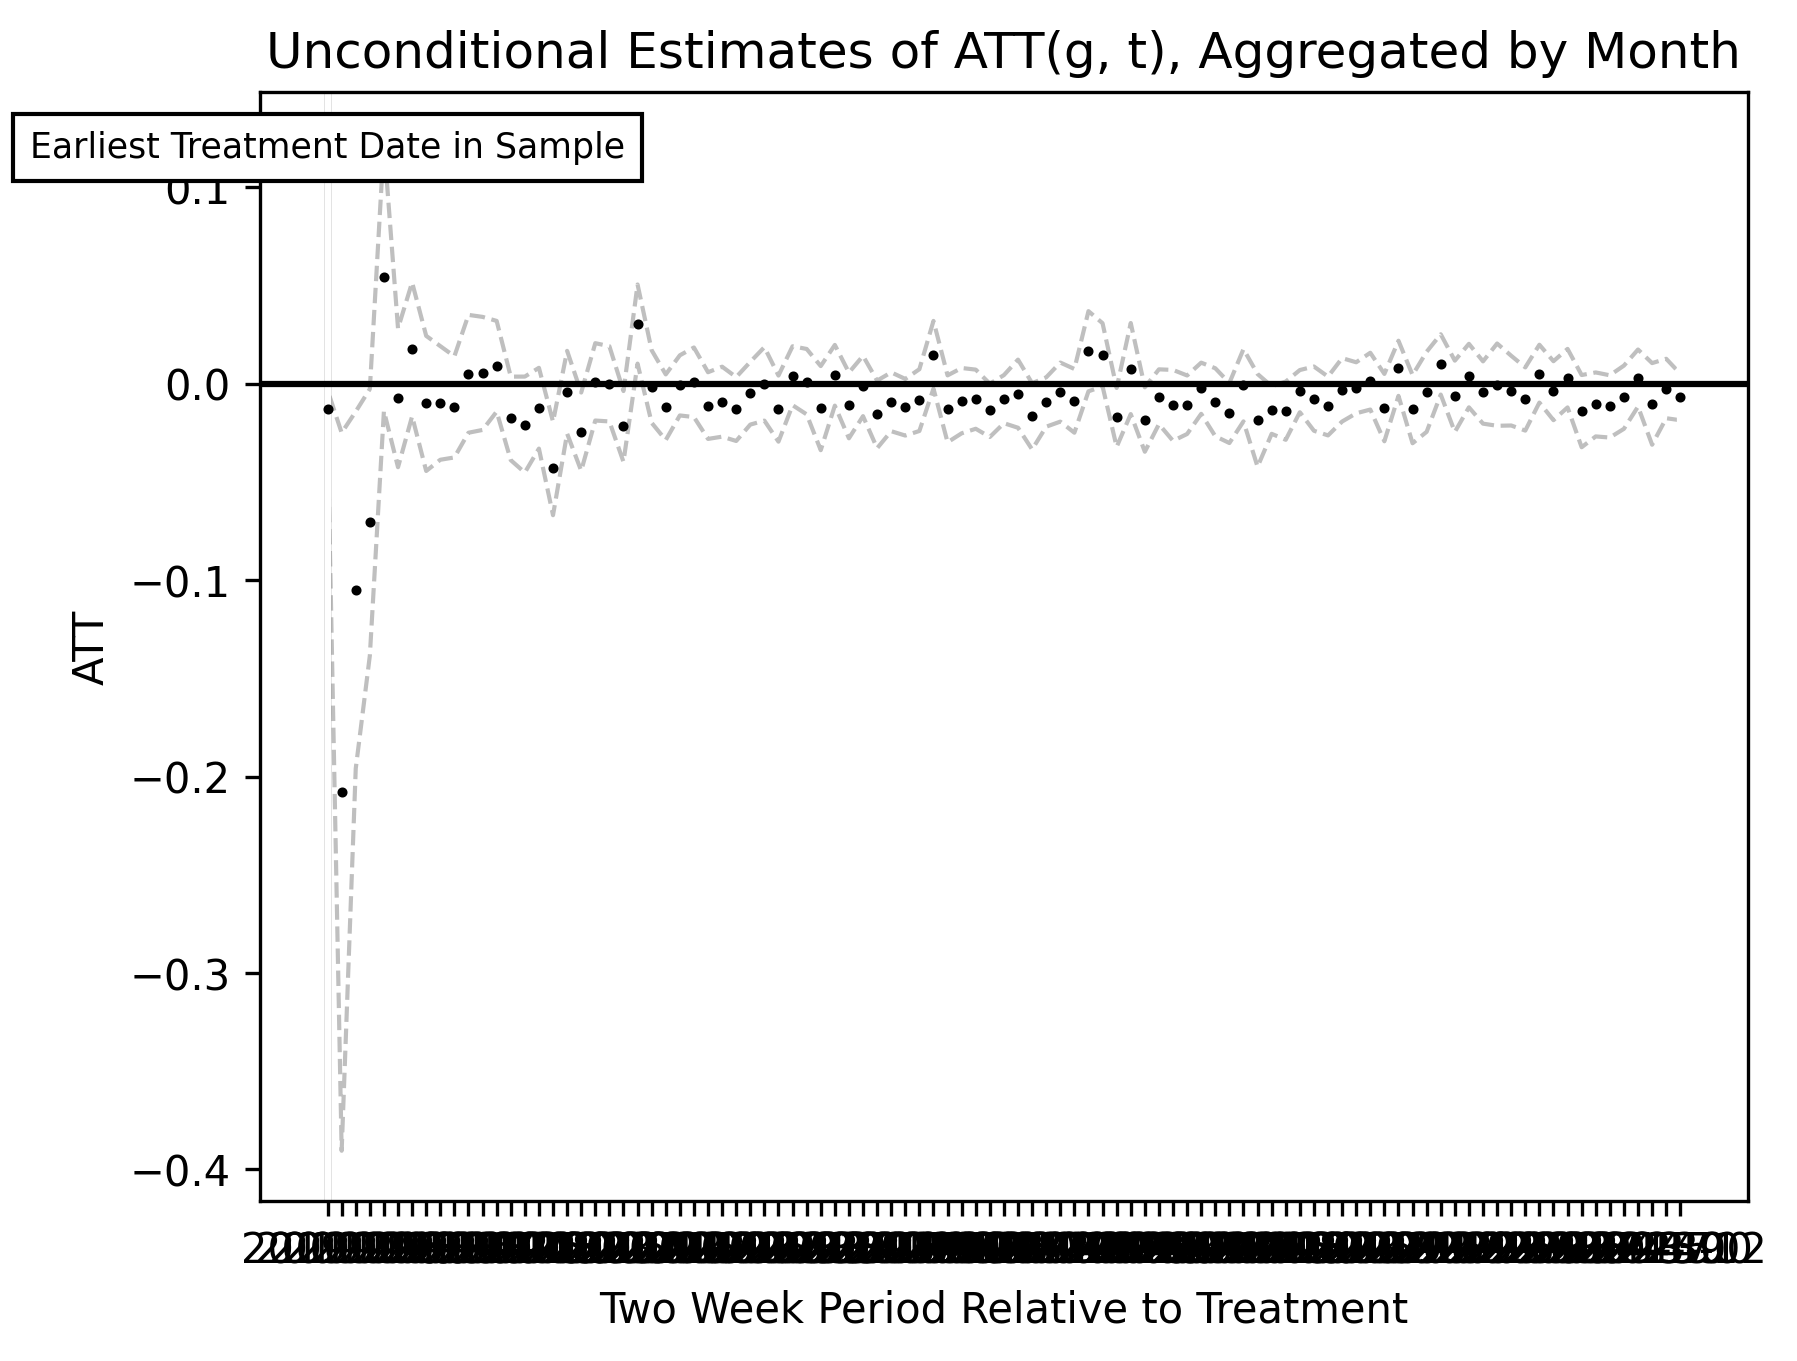

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=34]   39%|███████▉            | 7011/17776 [00:27<00:39, 274.73it/s]/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site

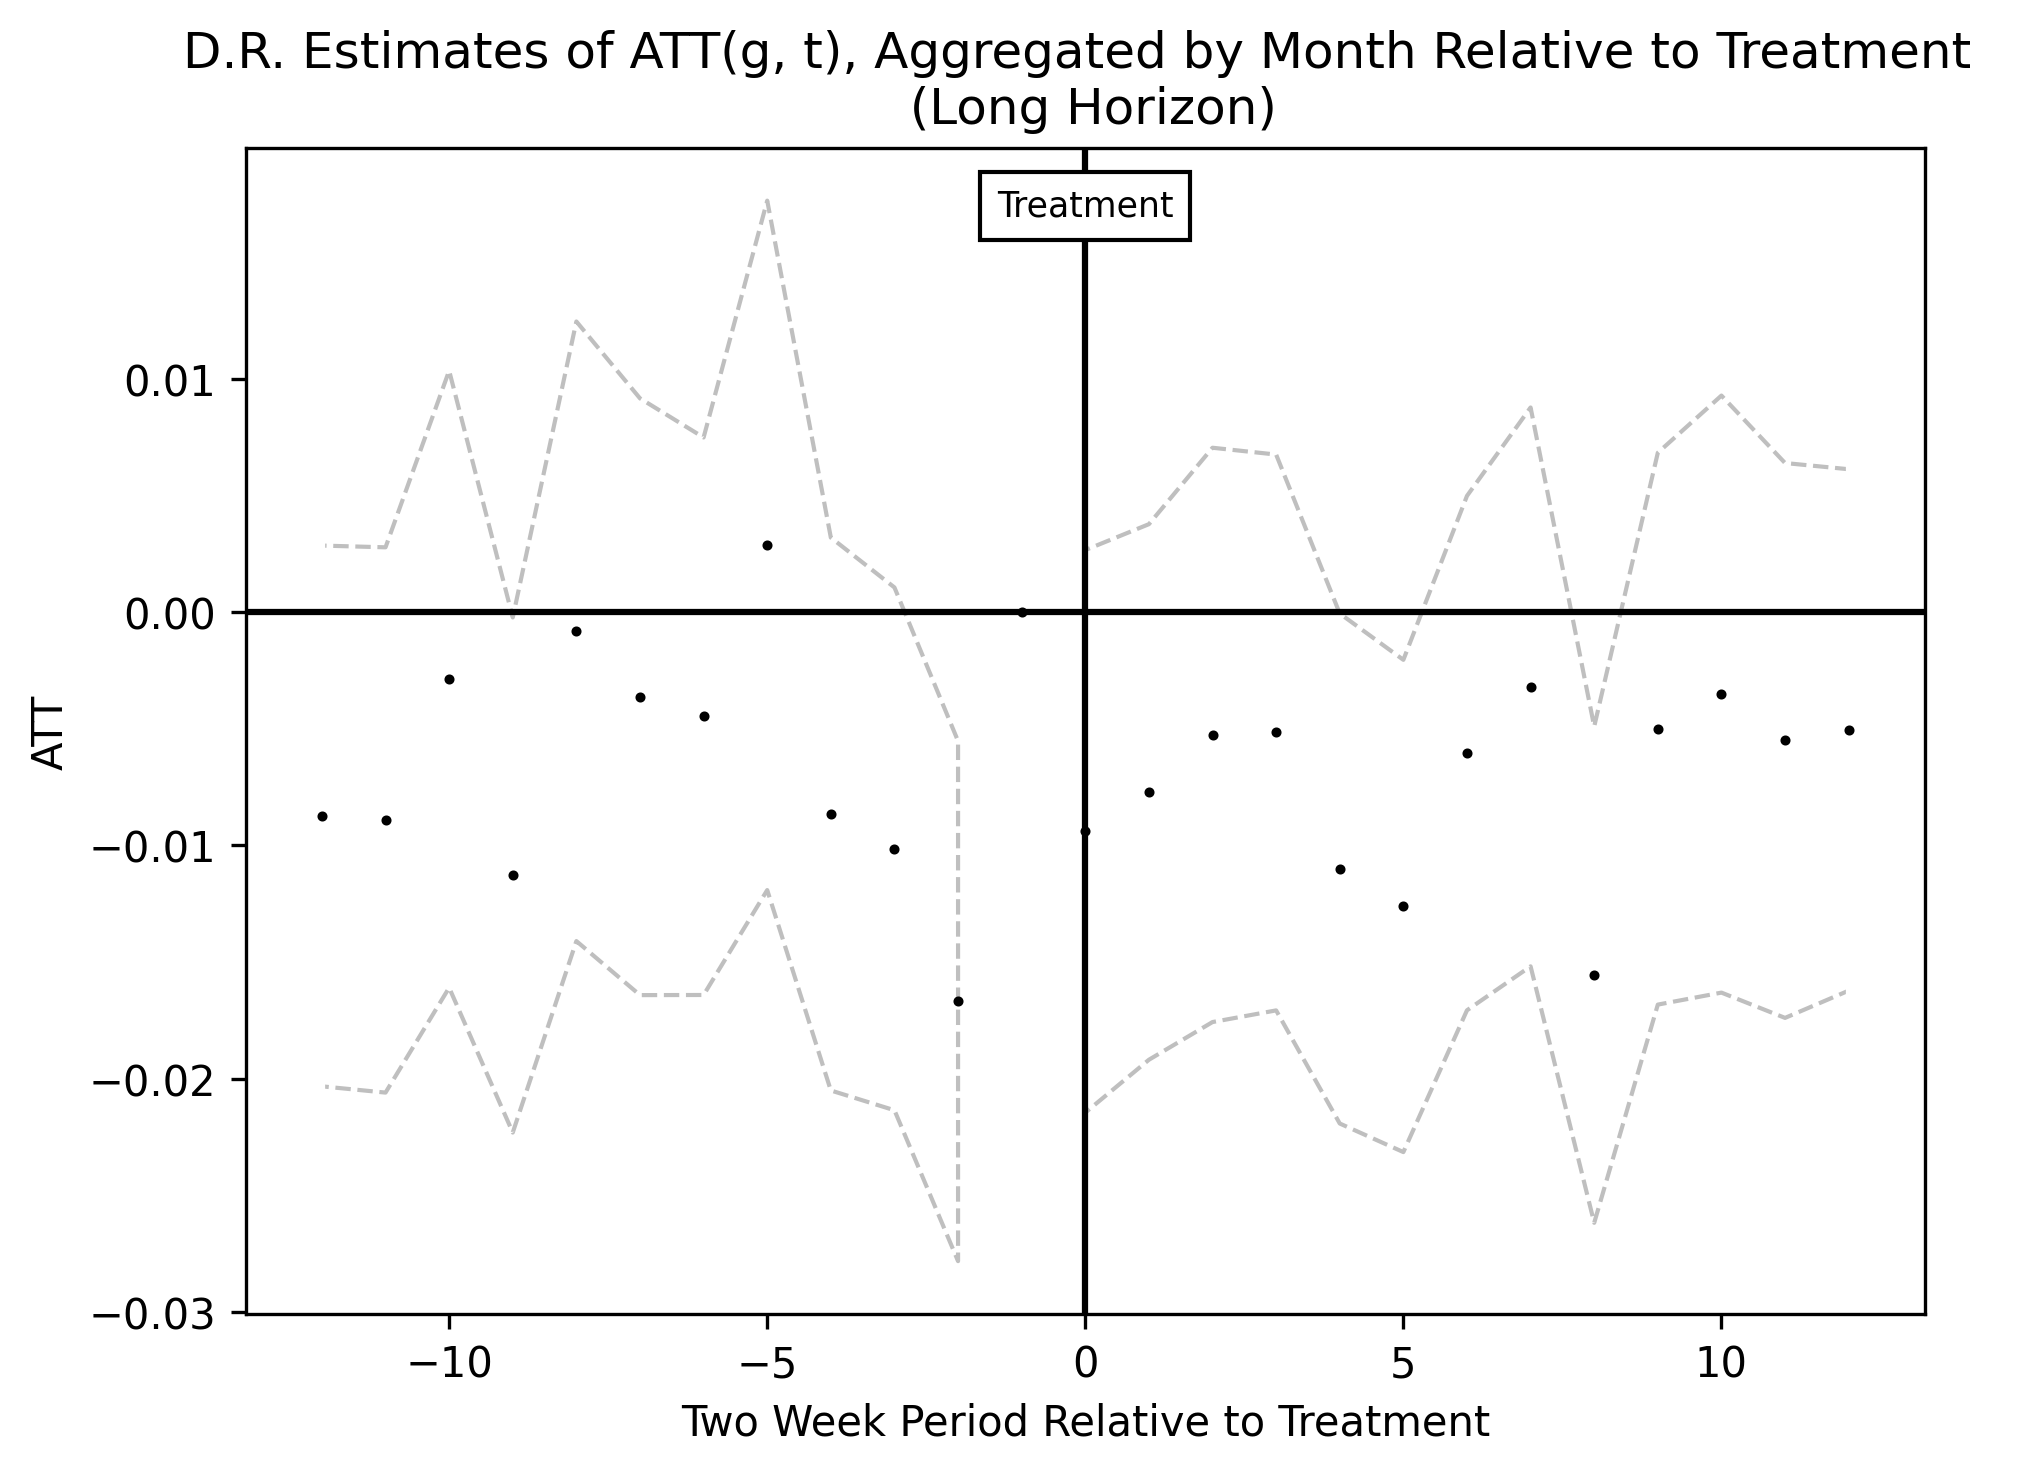

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=12,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

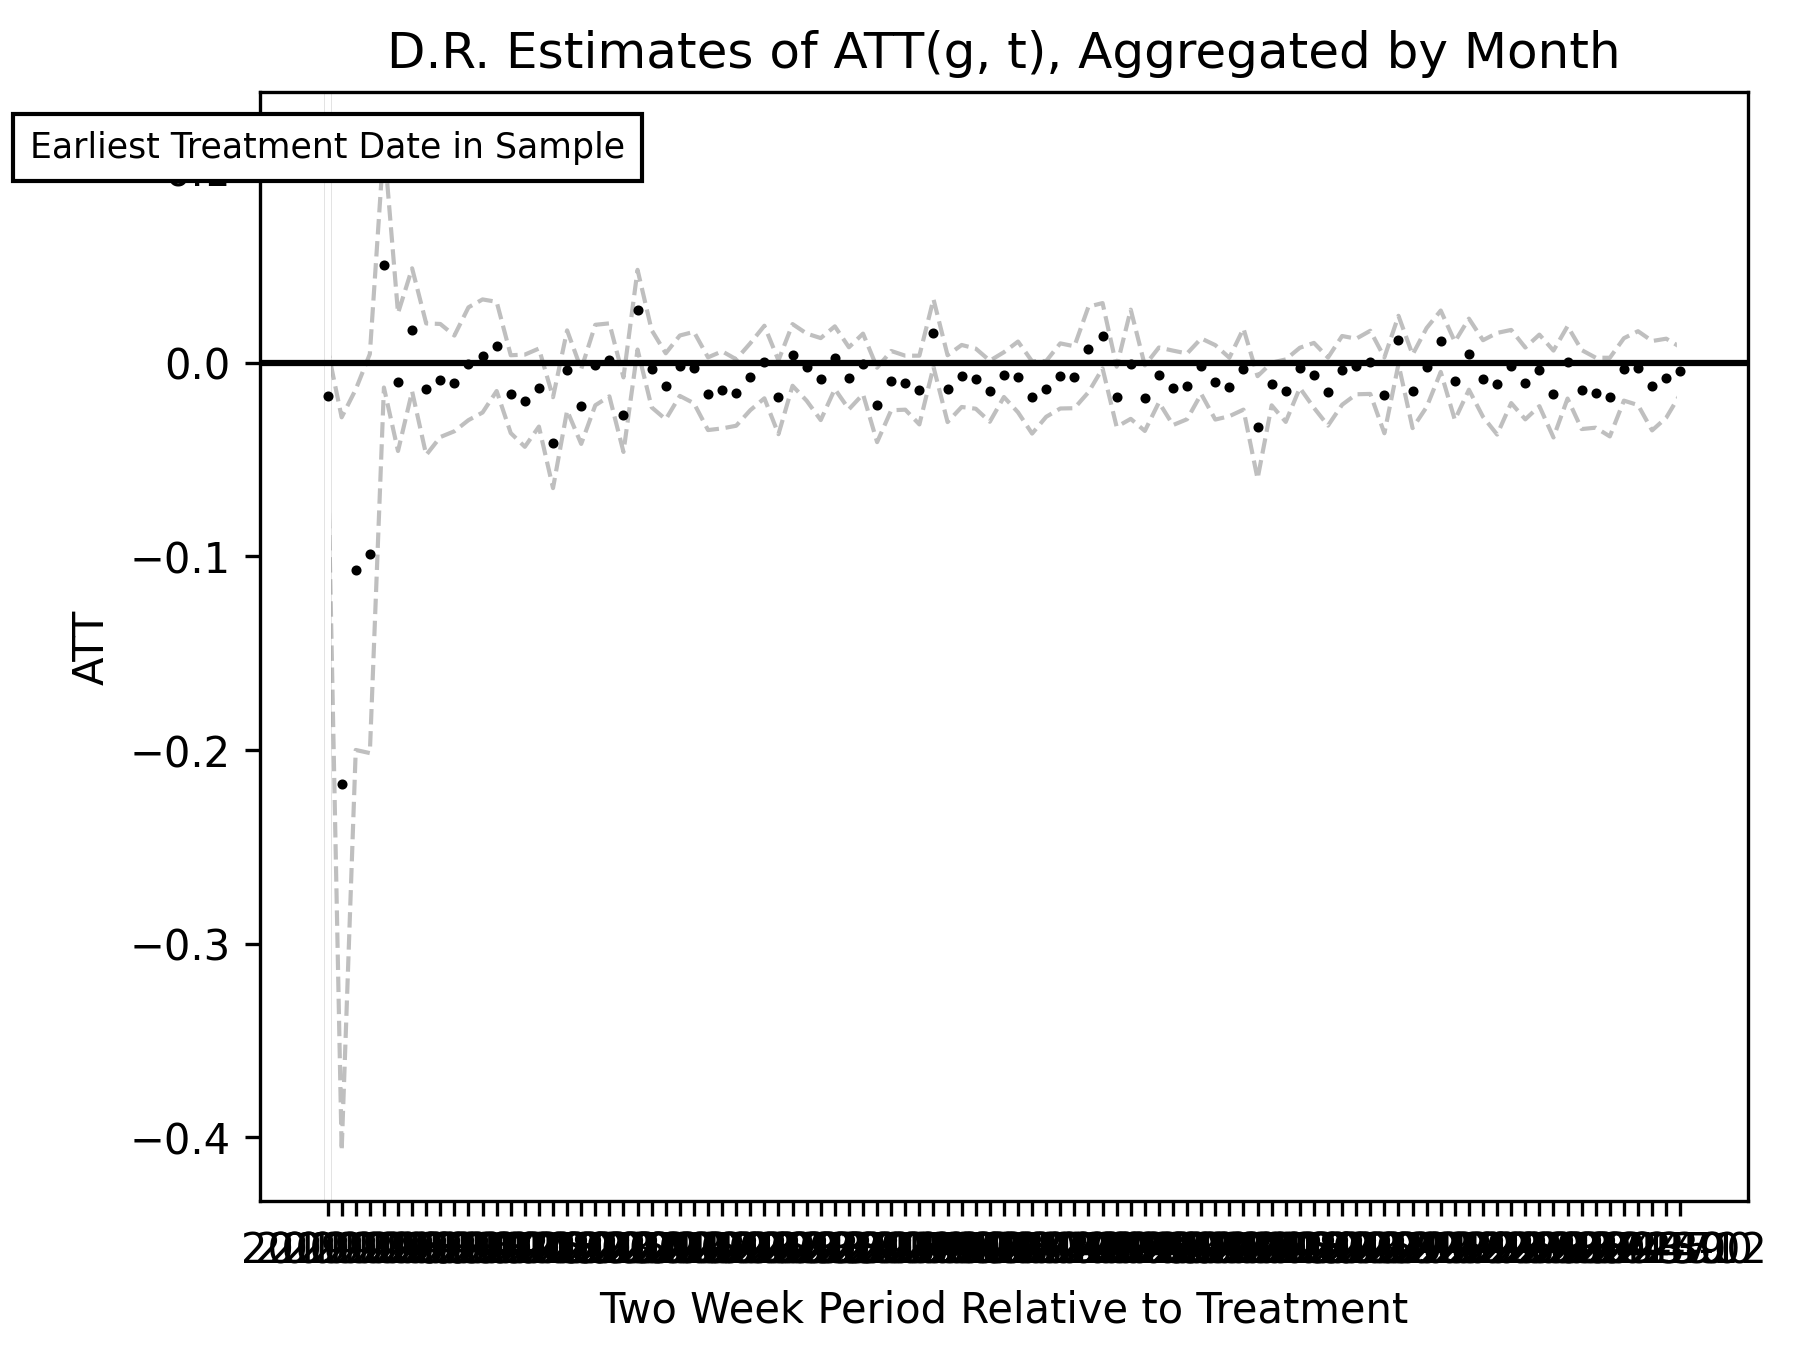

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")